In [9]:
# Notebook to study the gammas emmited from the 2nubb events
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import os
import sys
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib.colors import LogNorm  # Import LogNorm for logarithmic color scale
from matplotlib.cm import get_cmap

# Create a sequential colormap
cmap = get_cmap('viridis')  # You can choose any sequential colormap here

In [3]:
# Loading in the file
files = []

files.append("xesphere_singleeminus_1_bar_2.5_MeV.h5")
files.append("xesphere_bb_1_bar_2.5_MeV.h5")

print(files)

config_v = []
parts_v  = []
hits_v   = []
energy_v = []
pressure_v = []
 
 
for index, f in enumerate(files):
    config_v.append(pd.read_hdf("../data/nexus/1bar/" + f, 'config'))
    parts_v .append(pd.read_hdf("../data/nexus/1bar/" + f, 'parts'))
    hits_v  .append(pd.read_hdf("../data/nexus/1bar/" + f, 'hits'))

    eventtype = config_v[index][config_v[index]["param_key"] == "/nexus/RegisterGenerator"].iloc[0]['param_value']

    if (eventtype == "Decay0Interface"):
        eventtype = "bb"
        energy = "0nuBB"
        energy_v.append(energy)
    else:
        eventtype = "singleeminus"

        # Then also get the energy
        energy = config_v[index][ config_v[index]["param_key"] == "/Generator/SingleParticle/min_energy"].iloc[0]['param_value']
        energy = [float(num) if '.' in num else int(num) for num in energy.split() if num.replace('.', '', 1).isdigit()]
        energy_v.append(energy[0])
        print(energy[0])

    pressure = config_v[index][ config_v[index]["param_key"] == "/Geometry/XeSphere/pressure"].iloc[0]['param_value']
    pressure = [float(num) if '.' in num else int(num) for num in pressure.split() if num.replace('.', '', 1).isdigit()]
    pressure = f"{int(pressure[0])}_bar"
    pressure_v.append(pressure)

display(config_v[0])

['xesphere_singleeminus_1_bar_2.5_MeV.h5', 'xesphere_bb_1_bar_2.5_MeV.h5']
2.5


,param_key,param_value
0,event_type,background
1,num_events,5000
2,saved_events,5000
3,interacting_events,5000
4,/PhysicsList/RegisterPhysics,G4EmStandardPhysics_option4
5,/PhysicsList/RegisterPhysics,G4DecayPhysics
6,/PhysicsList/RegisterPhysics,G4RadioactiveDecayPhysics
7,/PhysicsList/RegisterPhysics,NexusPhysics
8,/PhysicsList/RegisterPhysics,G4StepLimiterPhysics
9,/nexus/RegisterGeometry,XeSphere


In [11]:
# Plot the distance of the gammas and bin in a histogram
gammas_v = []

for df in parts_v:
    gammas_v.append(df[df["particle_name"] == "gamma"])


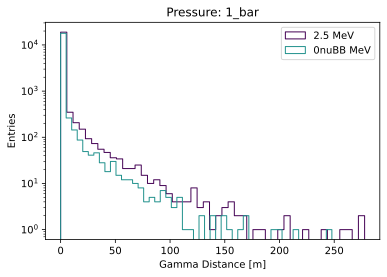

In [14]:
plt.figure()

dist_counts_v = []
dist_bins_v = []

pd.options.mode.chained_assignment = None  # Set it to "None" to disable the warning

for index, g in enumerate(gammas_v):
    deltax = g['final_x'] - g['initial_x']
    deltay = g['final_y'] - g['initial_y']
    deltaz = g['final_z'] - g['initial_z']

    # g['distances'] = np.sqrt(g['final_x']*g['final_x'] + g['final_y']*g['final_y'] + g['final_z']*g['final_z'])/1000
    g['distances'] =  np.sqrt( deltax**2 + deltay**2 + deltaz**2 )/1000
    # print(distances)

    # bin_edges = np.linspace(0, g['distances'].max(), 50000);
    bin_edges = np.linspace(0, g['distances'].max(), 50);
    # bin_edges = np.linspace(0, 20, 10000);

    counts, bins, _ = plt.hist(g['distances'] , bins = bin_edges, histtype='step', label = f"{energy_v[index]} MeV", color=cmap(index/len(gammas_v)))

    dist_counts_v.append(counts)
    dist_bins_v.append(bins)

plt.xlabel("Gamma Distance [m]")
# plt.xlim(0, gammas_v[4].distances.max()) 
plt.ylabel("Entries")
plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.title(f"Pressure: {pressure_v[0]}")
plt.legend()

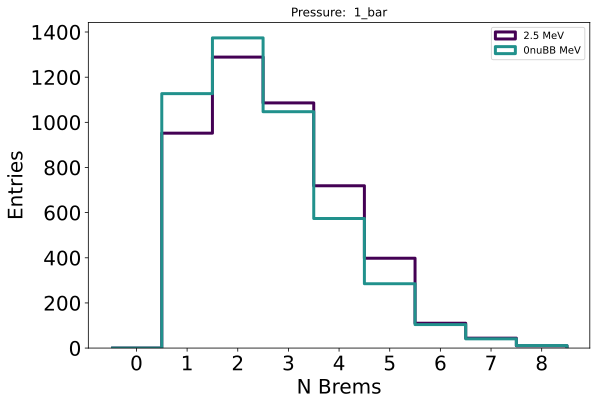

In [36]:
# Plt the bremstrahlung frequency per event
eBrems = []

for index, g in enumerate(gammas_v):
    eBrems.append(g[ g['creator_proc'] == "eBrem"])

bin_edges = np.arange(-0.5, 9.5, 1)
bin_centers = np.arange(0, 9, 1)


fig, ax1 = plt.subplots(figsize=(9,6))

for index, df in enumerate(eBrems):

    eventids = df.event_id.unique()

    n_photon_v = []

    for e in eventids:
        temp_df = df[ df["event_id"] == e]
        n_photon_v.append(len(temp_df))

    # plt.subplot(2, 3, index+1)
    ax1.hist(n_photon_v, bins = bin_edges, label = f"{energy_v[index]} MeV", color=cmap(index/len(eBrems)), histtype="step", linewidth = 3)
    
    # Create a twin y-axis (ax2) for percentages
    # ax2 = ax1.twinx()

    # Calculate the histogram as percentages relative to 500
    # hist, bins = np.histogram(n_photon_v, bins=bin_edges)
    # percentages = hist * 100 / 5000  # Divide by 5 (500/100) to normalize to 500 total
    # ax2.plot(bins[:-1], percentages, linestyle='-', marker='o', color='white')

    ax1.set_xlabel("N Brems", fontsize=20)
    ax1.set_ylabel("Entries", fontsize=20)
    ax1.legend()
    ax1.set_xticks(bin_centers) 
    ax1.set_title( f"Pressure:  {pressure_v[0]}")
    ax1.tick_params(axis='both', labelsize=20)  # Adjust the tick label font size as needed
    
    # ax2.tick_params(axis='both', labelsize=20)  # Adjust the tick label font size as needed
    # ax2.set_ylabel('Fraction of events [%]', fontsize=20, labelpad=20)
    # ax2.set_ylim(0, 100*1400/5000)

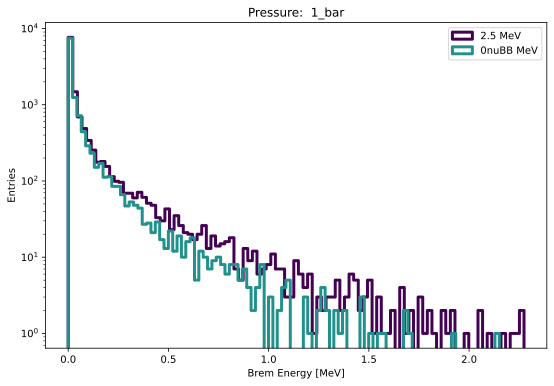

In [39]:
# Plot the gamma ray energy

plt.figure(figsize=(9,6))  # Adjust the figure size as needed

counts_v = []
bins_v = []


for index, df in enumerate(eBrems):

    n_photon_v = []
    bin_edges = np.linspace(0, df["kin_energy"].max(), 100);
    # bin_edges = np.linspace(0, 0.03, 100);
    counts, bins, _  = plt.hist(df["kin_energy"], bins = bin_edges, label = f"{energy_v[index]} MeV", color=cmap(index/len(eBrems)), histtype="step", linewidth=3, log = True);
    counts_v.append(counts)
    bins_v.append(bins)

    plt.xlabel("Brem Energy [MeV]")
    plt.ylabel("Entries")
    plt.title( f"Pressure:  {pressure_v[0]}")
    plt.legend()